In [2]:
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from eofs.standard import Eof

from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import filters
from toolbar.masked import masked
from toolbar.significance_test import corr_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import velovect, velovect_key
ols = np.load("D:\PyFile\paper1\OLS35_detrended.npy") # 读取站点数据
EHD = xr.open_dataset(fr"D:\PyFile\paper1\EHD35.nc")
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域EHD温度距平
EHD = EHD.sel(time=EHD['time.month'].isin([7, 8]))  # 截取7-8月数据
EHD_average = masked(EHD.groupby('time.year').sum('time'), r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").mean(['lat', 'lon'])['tmax'] # 计算长江流域EHD年平均

In [36]:
EHD_S2 = EHD.sum('lat', skipna=True).sum('lon', skipna=True) # 计算长江流域EHD年总和

In [37]:
EHD_S2 = EHD_S2**2/62

In [38]:
EHD_S2 = EHD_S2.groupby('time.year').sum('time', skipna=True)
EHD_S2 = EHD_S2['tmax'] - np.polyval(np.polyfit(np.arange(len(EHD_S2['tmax'])), EHD_S2['tmax'], 1), np.arange(len(EHD_S2['tmax'])))

In [40]:
np.corrcoef(EHD_S2, ols)

array([[1.        , 0.95024822],
       [0.95024822, 1.        ]])

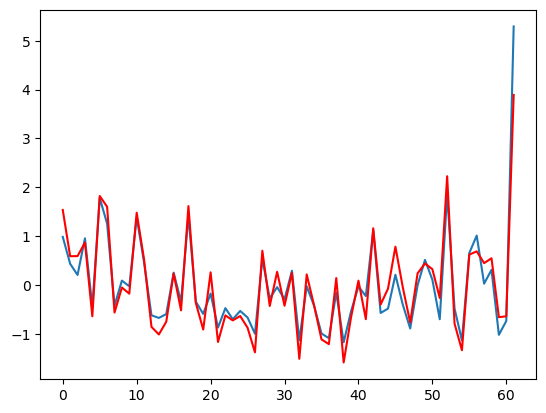

In [41]:
plt.plot((EHD_S2-EHD_S2.mean())/EHD_S2.std())
plt.plot(np.load("D:\PyFile\paper1\OLS35_detrended.npy"), color='r')

In [18]:
EHD_mean = masked(EHD.groupby('time.year').sum('time', skipna=True), r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")['tmax'] # 计算长江流域EHD年平均
EHD_detrended = np.zeros(EHD_mean.shape)
for j in tqdm.trange(len(EHD_mean[0, 0, :])):
    for i in range(len(EHD_mean[0])):
        if np.isnan(EHD_mean.mean('year')[i, j]):
            EHD_detrended[:, i, j] = np.nan
            continue
        EHD_detrended[:, i, j] = EHD_mean[:, i, j] - np.polyval(np.polyfit(np.arange(len(EHD_mean)), EHD_mean[:, i, j], 1), np.arange(len(EHD_mean)))

100%|██████████| 283/283 [09:23<00:00,  1.99s/it]


In [19]:
eof = Eof(EHD_detrended)
pattern = eof.eofs(eofscaling=2, neofs=2)
pc = eof.pcs(pcscaling=1, npcs=2)
s = eof.varianceFraction(neigs=2)

C:\Users\86136\AppData\Local\Temp\ipykernel_3404\2814418745.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  eof = Eof(EHD_detrended)


In [43]:
s

array([0.6440709 , 0.12500725])

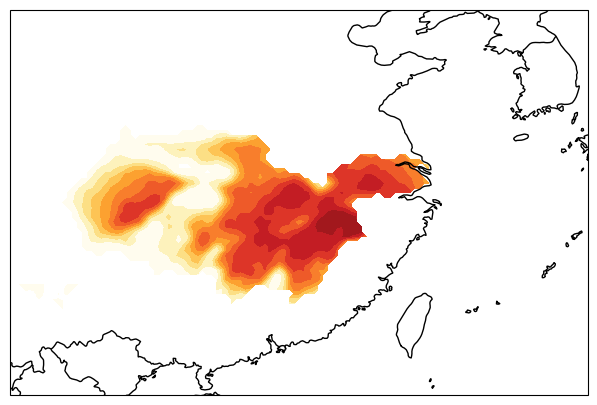

In [23]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([100, 130, 20, 40], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, linestyle='-')
ax.contourf(EHD_mean.mean('year').lon, EHD_mean.mean('year').lat, pattern[0]*-1, cmap=cmaps.BlueWhiteOrangeRed[125:], levels=10, transform=ccrs.PlateCarree())
plt.show()

In [134]:
EHD_detrended.shape


(62, 163, 283)